In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import scikitplot.metrics as skplt
import joblib

In [25]:
y = pd.read_csv("../Data/y_eng_oversampled.csv", header=None, names=["Y"])
bow = pd.read_csv('../Cache/Embeddings/bow.csv')
X_train, X_test, Y_train, Y_test = train_test_split(bow, y, random_state = 0, test_size = 0.3)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((8843, 65), (8843, 1), (3790, 65), (3790, 1))

In [3]:
train_df = pd.read_csv("../Data/eng_train_lda.csv")
test_df = pd.read_csv("../Data/eng_test_lda.csv")
X_train = train_df.drop(columns=["Y", "Unnamed: 0"])
Y_train = train_df["Y"]
X_test = test_df.drop(columns=["Y", "Unnamed: 0"])
Y_test = test_df["Y"]
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,Sub-task B
0,0.012821,0.012821,0.012821,0.012821,0.012821,0.012821,0.012821,0.012821,0.012821,0.012821,...,0.012821,0.012821,0.012821,0.346154,0.012821,0.346154,0.012821,16,3,1
1,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.003497,0.365459,0.003497,...,0.003497,0.459717,0.003497,0.003497,0.003497,0.003497,0.003497,287,37,1
2,0.001748,0.001748,0.721673,0.001748,0.001748,0.001748,0.078715,0.001748,0.001748,0.001748,...,0.001748,0.001748,0.047201,0.001748,0.001748,0.001748,0.001748,295,40,0
3,0.006410,0.006410,0.006410,0.006410,0.006410,0.006410,0.006410,0.006410,0.006410,0.339752,...,0.006410,0.006410,0.006410,0.006410,0.173073,0.006410,0.006410,64,8,0
4,0.005495,0.005495,0.005495,0.148341,0.005495,0.148354,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.148355,0.291214,69,9,1


In [4]:
def run_the_mn_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'mnb1':
        
        mn_params = {
            'fit_prior': [True],
            'alpha': [0, 0.5, 1]}
        
        M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'mnb2':
        
         mn_params = {
            'fit_prior': [False],
            'alpha': [0, 0.5, 1]}
        
         M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print('There is an error.')
        
    M.fit(X_train_text_df.values, y_train)
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     #skplt.plot_roc_curve(predictions,y_test)
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    3.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.7s finished


Train score = 0.7761394101876675
Test score = 0.7542213883677298
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'alpha': 1, 'fit_prior': True}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

         CAG       0.23      0.05      0.08       193
         NAG       0.80      0.95      0.87      1244
         OAG       0.22      0.13      0.16       162

    accuracy                           0.75      1599
   macro avg       0.42      0.37      0.37      1599
weighted avg       0.67      0.75      0.70      1599



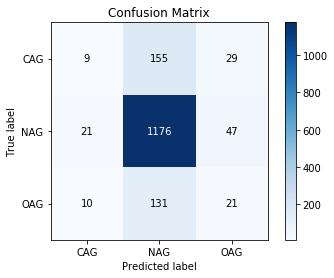

In [5]:
run_the_mn_models("mnb1", X_train, X_test, Y_train, Y_test)

In [6]:
def run_the_lr_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    
    if model == 'lr1':
        
        lr_1_params = {
            'penalty': ['l1'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],
            'random_state': [42],
            'solver': ['liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_1_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'lr2':
        
        lr_2_params = {
            'penalty': ['l2'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],            
            'random_state': [42],
            'solver': ['lbfgs', 'liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_2_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)

    else:
        print('There is an error.')
        
    M.fit(X_train_text_df.values, y_train)
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.5s finished


Train score = 0.7812332439678285
Test score = 0.7636022514071295
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'warm_start': True}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

         CAG       0.30      0.16      0.20       193
         NAG       0.83      0.92      0.87      1244
         OAG       0.39      0.31      0.35       162

    accuracy                           0.76      1599
   macro avg       0.51      0.46      0.48      1599
weighted avg       0.72      0.76      0.74      1599



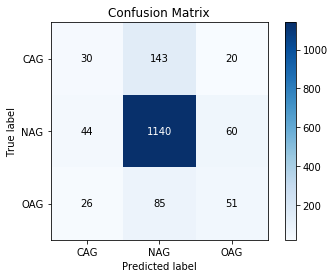

In [7]:
run_the_lr_models("lr2", X_train, X_test, Y_train, Y_test)

In [8]:
def run_the_sv_models(model, X_train, X_test, Y_tr, Y_te):   
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'sv1':
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000] }
        
        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'sv2':
        
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [0.01, 1, 10, 100],
            'C': [1, 10, 100, 1000] }

        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print("Invalid Model!")
        
    M.fit(X_train_text_df.values, y_train)
      
    #save in pickle file
    joblib.dump(M, "SVM_TFIDF.pkl")
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.0min finished


Train score = 0.8126005361930295
Test score = 0.7798624140087554
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

         CAG       0.31      0.02      0.04       193
         NAG       0.79      0.98      0.88      1244
         OAG       0.52      0.15      0.23       162

    accuracy                           0.78      1599
   macro avg       0.54      0.38      0.38      1599
weighted avg       0.71      0.78      0.71      1599



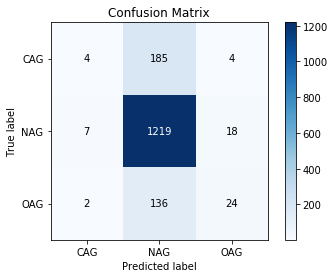

In [9]:
run_the_sv_models("sv2", X_train, X_test, Y_train, Y_test)